In [4]:
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
import torch.functional as F 
from torch import nn


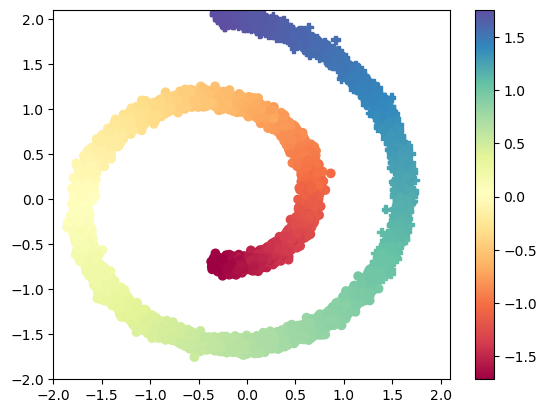

In [55]:
np.random.seed(42)

swiss_roll, t_raw = datasets.make_swiss_roll(10000, noise=0.3)

def normalise(array: np.array):
    shifted = array - np.mean(array)
    scaled = shifted / np.std(array)
    return scaled 

swiss_roll = normalise(swiss_roll)
t = normalise(t_raw)

markers = {True: "o",
           False: "P"}

split = t <= 1
fig, ax = plt.subplots()

norm = colors.Normalize(vmin=t.min(), vmax=t.max())
cmap = "Spectral"

for side in (True, False):
    msk = split == side
    sc = ax.scatter(normalise(swiss_roll.T[0])[msk], 
                    normalise(swiss_roll.T[2])[msk], 
                    c=t[msk], cmap=cmap, norm=norm,
                    marker=markers[side])
    
    ax.set_xlim(-2, 2.1)
    ax.set_ylim(-2, 2.1)

fig.colorbar(sc)

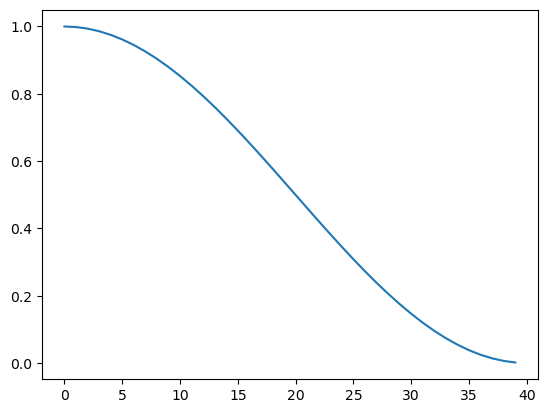

In [89]:
X = torch.tensor(swiss_roll[:, [0, 2]], dtype=torch.float32)

diffusion_steps = 40 
s = 0.0008
t = torch.arange(0, 40, 1)

schedule = torch.cos((t/diffusion_steps + s) / (1 + s) * torch.pi / 2) ** 2
bar_alphas = schedule / schedule[0]
alphas = bar_alphas / torch.concat((bar_alphas[0:1], bar_alphas[0:-1]))
betas = 1 - alphas 

plt.plot(bar_alphas)


In [165]:
noiselevel = 20

def noise(x, t):
    eps = torch.randn_like(x)
    mu = (bar_alphas[t] ** 0.5).repeat(1, x.shape[1]) * x
    var = ((1 - bar_alphas[t]) ** 0.5).repeat(1, x.shape[1]) * eps

    return mu + var, eps

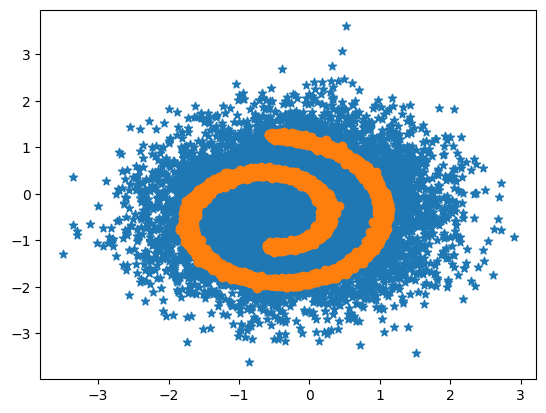

In [166]:
noisy_x, eps = noise(X, 20) 

plt.scatter(noisy_x[:, 0], noisy_x[:, 1], marker = "*")
plt.scatter(X[:, 0], X[:, 1], marker = "o")

In [167]:
noisy_x.shape

torch.Size([10000, 2])

In [168]:
unnoised = 1 / bar_alphas[20] ** 0.5 * (noisy_x - (1 - bar_alphas[20]) ** 0.5 * eps) 

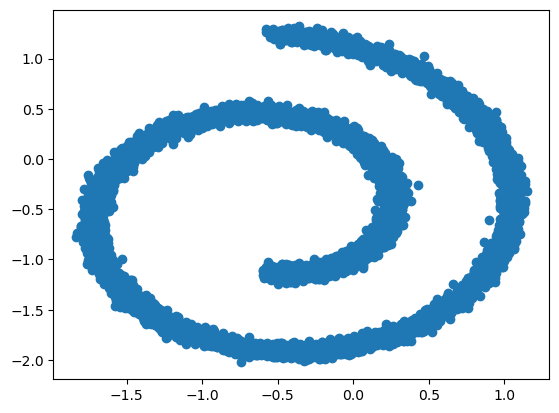

In [169]:
plt.scatter(unnoised[:, 0], unnoised[:, 1])

In [170]:
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x):
        x = self.linear(x)
        return nn.functional.relu(x)

class DiffusionModel(nn.Module):
    def __init__(self, n_features, n_blocks=4, n_units=64): 
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(n_features + 1, n_units)
        self.blocks = nn.ModuleList([
            DiffusionBlock(n_units) for _ in range(n_blocks)
        ])
        self.outblock = nn.Linear(n_units, n_features)

    def forward(self, x, t):
        x = torch.hstack((x, t))
        x = self.inblock(x)
        for block in self.blocks:
            x = block(x)
        return self.outblock(x)


In [171]:
model = DiffusionModel(2, 4, 64) 

device = 'cpu'

model.to(device)

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

In [176]:
import torch.optim as optim

batch_size = 2048
n_epochs = 100


loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimiser, start_factor=1.0, end_factor=0.01, total_iters=n_epochs)

for epoch in range(n_epochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        XBatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(XBatch), 1])
        Xnoise, eps = noise(XBatch, timesteps)
        pred_eps = model(Xnoise.to(device), timesteps.to(device))
        loss = loss_fn(pred_eps, eps.to(device))
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        steps += 1 
        epoch_loss += loss
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")


Epoch 0 loss = 0.51873379945755
Epoch 1 loss = 0.45618993043899536
Epoch 2 loss = 0.4319585859775543
Epoch 3 loss = 0.4244965612888336
Epoch 4 loss = 0.42598384618759155
Epoch 5 loss = 0.40059417486190796
Epoch 6 loss = 0.39880743622779846
Epoch 7 loss = 0.4075353741645813
Epoch 8 loss = 0.4104282259941101
Epoch 9 loss = 0.4023140072822571
Epoch 10 loss = 0.4097915589809418
Epoch 11 loss = 0.40170803666114807
Epoch 12 loss = 0.40520328283309937
Epoch 13 loss = 0.40984028577804565
Epoch 14 loss = 0.4191613793373108
Epoch 15 loss = 0.39833587408065796
Epoch 16 loss = 0.40254640579223633
Epoch 17 loss = 0.3979937434196472
Epoch 18 loss = 0.3968455195426941
Epoch 19 loss = 0.4119959771633148
Epoch 20 loss = 0.4016593098640442
Epoch 21 loss = 0.4078797399997711
Epoch 22 loss = 0.40483030676841736
Epoch 23 loss = 0.4152145981788635
Epoch 24 loss = 0.4079814851284027
Epoch 25 loss = 0.4069310128688812
Epoch 26 loss = 0.4106680750846863
Epoch 27 loss = 0.40459975600242615
Epoch 28 loss = 0.406

In [ ]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-bar_alphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt